### Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

### Load the dataset

In [ ]:
df = pd.read_csv('Shampoo_Sales.csv')

In [ ]:
df.head()

In [ ]:
df.rename(columns={'Sales of shampoo over a three year period': 'Sales'}, inplace=True)

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df['Month'] = df.Month.apply(lambda x: "202"+x)

In [ ]:
df

,Month,Sales
0,2021-01,266.0
1,2021-02,145.9
2,2021-03,183.1
3,2021-04,119.3
4,2021-05,180.3
5,2021-06,168.5
6,2021-07,231.8
7,2021-08,224.5
8,2021-09,192.8
9,2021-10,122.9


In [ ]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Month,37,37,2021-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sales,36.0,NaN,NaN,NaN,312.6,148.937164,119.3,192.45,280.15,411.1,682.0


In [ ]:
df.isnull().sum()

Month    0
Sales    1
dtype: int64

In [ ]:
df.dropna(subset=['Sales'], inplace=True)

In [ ]:
df.shape

(36, 2)

In [13]:
df = df.set_index("Month")
df.head()

,Sales
Month,
2021-01,266.0
2021-02,145.9
2021-03,183.1
2021-04,119.3
2021-05,180.3


### Exploratory Data Analysis (EDA)

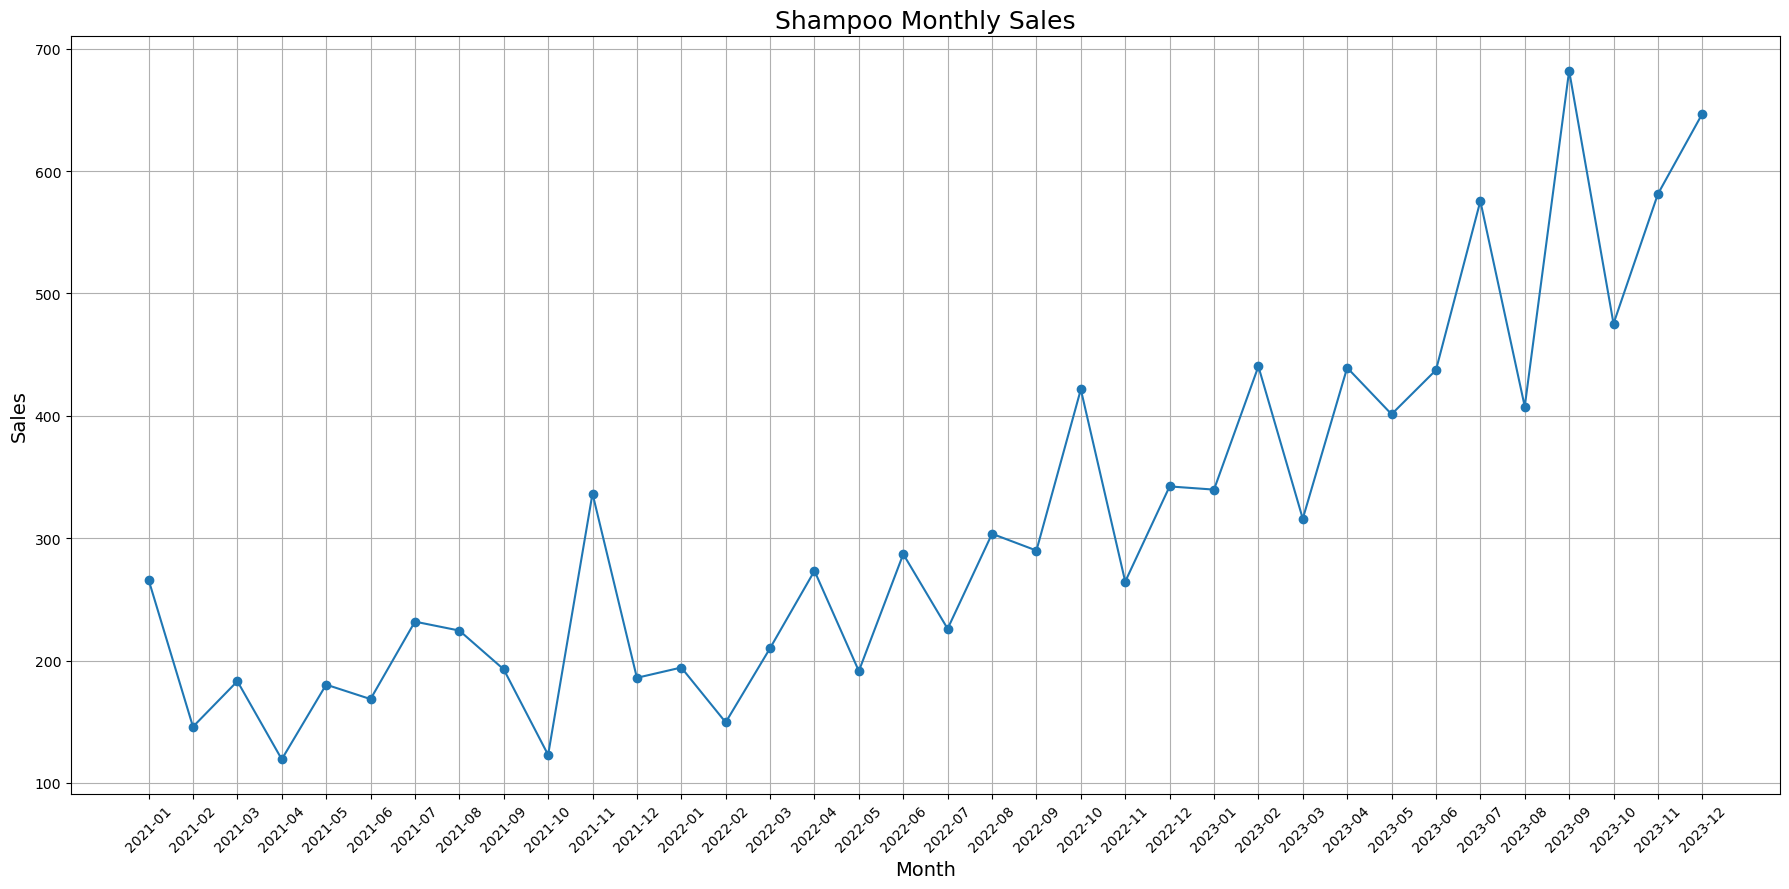

In [14]:
# Plotting
plt.figure(figsize=(18,9))
plt.plot(df.index, df['Sales'], marker='o', linestyle='-')
plt.title('Shampoo Monthly Sales', fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Seasonal Decompose

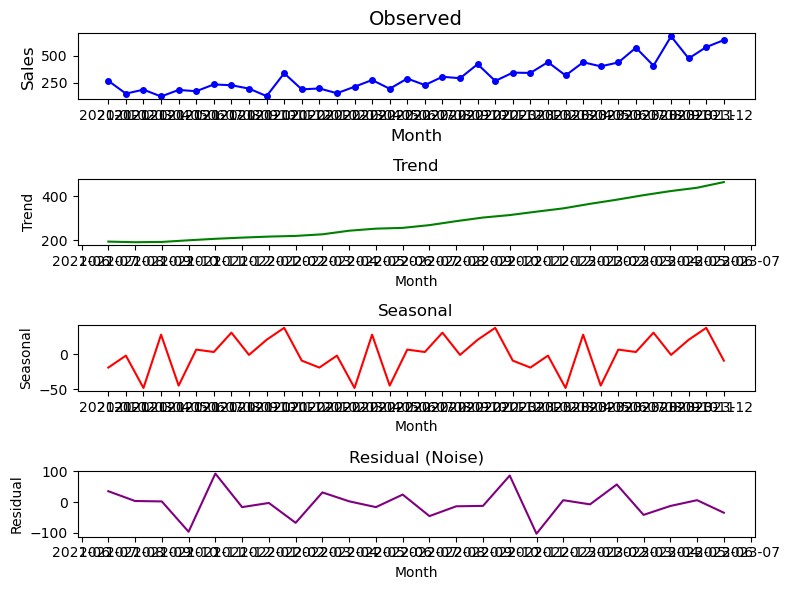

In [16]:
res = seasonal_decompose(df['Sales'], period=12)
plt.figure(figsize=(8, 6))

# Plot observed
plt.subplot(4, 1, 1)
plt.plot(res.observed, color='blue', linestyle='-', linewidth=1.5, marker='o', markersize=4)
plt.title('Observed', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sales', fontsize=12)

# Plot trend
plt.subplot(4, 1, 2)
plt.plot(res.trend, color='green', linestyle='-', linewidth=1.5)
plt.title('Trend', fontsize=12)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Trend', fontsize=10)

# Plot seasonal
plt.subplot(4, 1, 3)
plt.plot(res.seasonal, color='red', linestyle='-', linewidth=1.5)
plt.title('Seasonal', fontsize=12)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Seasonal', fontsize=10)

# Plot residual (noise)
plt.subplot(4, 1, 4)
plt.plot(res.resid, color='purple', linestyle='-', linewidth=1.5)
plt.title('Residual (Noise)', fontsize=12)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Residual', fontsize=10)

plt.tight_layout()
plt.show()

### Check for stationarity

In [17]:
result = adfuller(df['Sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.060142
p-value: 1.000000


### Differencing to make the series stationary

In [18]:
# If p-value > 0.05, we consider the series to be non-stationary
if result[1] > 0.05:
    # Differencing to make the series stationary
    df['Sales_diff'] = df['Sales'].diff().dropna()
    df.dropna(inplace=True) 

### Check for stationarity again

In [19]:
result_diff = adfuller(df['Sales_diff'].dropna())
print('ADF Statistic after differencing: %f' % result_diff[0])
print('p-value after differencing: %f' % result_diff[1])

ADF Statistic after differencing: -7.249074
p-value after differencing: 0.000000


### ARIMA Model

In [20]:
# Since the data is now stationary, we can fit the ARIMA model
model_arima = ARIMA(df['Sales_diff'], order=(1, 1, 1))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Sales_diff   No. Observations:                   35
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -197.042
Date:                Thu, 09 May 2024   AIC                            400.083
Time:                        15:20:39   BIC                            404.663
Sample:                    02-01-2021   HQIC                           401.645
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7327      0.126     -5.822      0.000      -0.979      -0.486
ma.L1         -0.9446      0.142     -6.631      0.000      -1.224      -0.665
sigma2      5632.7571   1646.512      3.421      0.0

### Forecasting with ARIMA

In [54]:
arima_forecast = model_arima_fit.forecast(steps=9)
print(arima_forecast)

2024-01-01   -19.909565
2024-02-01    42.742954
2024-03-01    -3.162298
2024-04-01    30.472298
2024-05-01     5.828363
2024-06-01    23.884876
2024-07-01    10.654941
2024-08-01    20.348462
2024-09-01    13.246058
Freq: MS, Name: predicted_mean, dtype: float64


### Normalize the data

In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df['Sales_diff'].values.reshape(-1, 1))

In [28]:
# Prepare the data for LSTM
time_steps = 1
X, y = [], []
for i in range(len(df_scaled) - time_steps):
    X.append(df_scaled[i:(i + time_steps), 0])
    y.append(df_scaled[i + time_steps, 0])
X, y = np.array(X), np.array(y)

In [29]:
# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

### Build the LSTM model

In [30]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_steps, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

### Fit the LSTM model

In [31]:
model_lstm.fit(X, y, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2294
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1402
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0528
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0554
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0659
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0855
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0554
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0653
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0566
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0436
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0578
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0379   
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0435
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0443
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0358
E

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0253
Epoch 82/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296
Epoch 83/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0328
Epoch 84/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0255
Epoch 85/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178
Epoch 86/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0299
Epoch 87/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191
Epoch 88/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0261   
Epoch 89/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125
Epoch 90/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177
Epoch 91/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204
Epoch 92/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235
Epoch 93/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0305
Epoch 94/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205
Epoch 95/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0318
Epoch

### Forecasting with LSTM

In [51]:
lstm_forecast = model_lstm.predict(X[2].reshape((1, time_steps, 1)))
lstm_forecast = scaler.inverse_transform(lstm_forecast) 
print('LSTM Forecast:', lstm_forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
LSTM Forecast: [[74.84523]]
